# GROUP 6 PROJECT 
#### Members: Kaylie Nguyen, Chi Pham, Rohan Shan, Max Xu

In [1]:
library(dplyr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Introduction

## Preliminary Results

First, we will read the dataset that has already been downloaded from the website as the data on the website is time sensitive. It'll be updated every 10 seconds. The version we're using was downloaded on Oct 30th, 2022.

In [2]:
df <- read.csv("america_2022-10-30-2.csv")
head(df)

,Ticker,Description,Price,Market.Capitalization,Enterprise.Value..MRQ.,Free.Cash.Flow..Annual.YoY.Growth.,EBITDA..Annual.YoY.Growth.,EPS.Diluted..Annual.YoY.Growth.,Gross.Profit..Annual.YoY.Growth.,Net.Income..Annual.YoY.Growth.,Yearly.Performance,Monthly.Performance,Change..,Gross.Margin..TTM.,Operating.Margin..TTM.,Pretax.Margin..TTM.,Net.Margin..TTM.,Industry
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAPL,Apple Inc.,155.74,2.477530e+12,2.50888e+12,19.891773,8.573353,8.892056,11.74200,5.410858,3.951408,5.4863181,12.6917511,43.30963,30.288744,30.204043,25.309641,Telecommunications Equipment
2,MSFT,Microsoft Corporation,235.87,1.758287e+12,1.71313e+12,16.092876,21.068848,19.786428,17.05911,18.715216,-27.273568,-0.3969427,1.2752254,68.26000,41.690508,41.740244,34.366121,Packaged Software
3,GOOG,Alphabet Inc.,96.58,1.248046e+12,1.25745e+12,56.412950,66.239223,91.418432,50.12498,88.812734,-34.432685,-1.4690879,0.4472179,55.86563,27.465095,28.003549,23.872310,Internet Software/Services
4,AMZN,"Amazon.com, Inc.",103.41,1.054953e+12,1.25309e+12,-156.804505,22.212676,54.889303,29.27591,56.410857,-39.208047,-9.5908376,-8.4867257,43.04438,2.688021,1.983309,2.254720,Internet Retail
5,TSLA,"Tesla, Inc.",228.52,7.216096e+11,9.05545e+11,83.806713,117.956441,667.843691,105.21870,700.579710,-35.827251,-19.2737036,-13.8473139,26.61261,16.710525,16.524852,14.936618,Motor Vehicles
6,BRK.A,Berkshire Hathaway Inc.,451900.00,6.671907e+11,6.29393e+11,-2.301857,12.738163,122.963852,13.07806,111.178006,3.956099,11.8196929,11.1767166,19.72554,13.559755,4.411983,4.041525,Multi-Line Insurance


Since we're comparing the raw material industry vs the rest of the market, we'll first filter the dataset to see the examples in the raw material industry. Since the industry names are specific, we will have to manually look up the names in the 'industry' column and pick them out.

In [3]:
unique(df["Industry"])

,Industry
,<chr>
1,Telecommunications Equipment
2,Packaged Software
3,Internet Software/Services
4,Internet Retail
5,Motor Vehicles
6,Multi-Line Insurance
7,Managed Health Care
8,Integrated Oil
9,Pharmaceuticals: Major


In [12]:
raw_material <- c("Agricultural Commodities/Milling", "Aluminum","Chemicals: Agricultural","Chemicals: Major Diversified","Chemicals: Specialty",
                 "Coal","Food Distributors","Food: Major Diversified","Food: Meat/Fish/Dairy","Food: Specialty/Candy","Forest Products","Gas Distributors",
                 "Integrated Oil","Oil & Gas Pipelines","Oil & Gas Production","Oil Refining/Marketing","Other Metals/Minerals", "Precious Metals",
                 "Steel","Textiles","Tobacco","Water Utilities")

df <- df %>%
    select(Ticker, Yearly.Performance, Industry) %>%
    mutate(Raw_material = if_else(Industry %in% raw_material, "Yes", "No"))     

head(df)

,Ticker,Yearly.Performance,Industry,Raw_material
,<chr>,<dbl>,<chr>,<chr>
1,AAPL,3.951408,Telecommunications Equipment,No
2,MSFT,-27.273568,Packaged Software,No
3,GOOG,-34.432685,Internet Software/Services,No
4,AMZN,-39.208047,Internet Retail,No
5,TSLA,-35.827251,Motor Vehicles,No
6,BRK.A,3.956099,Multi-Line Insurance,No


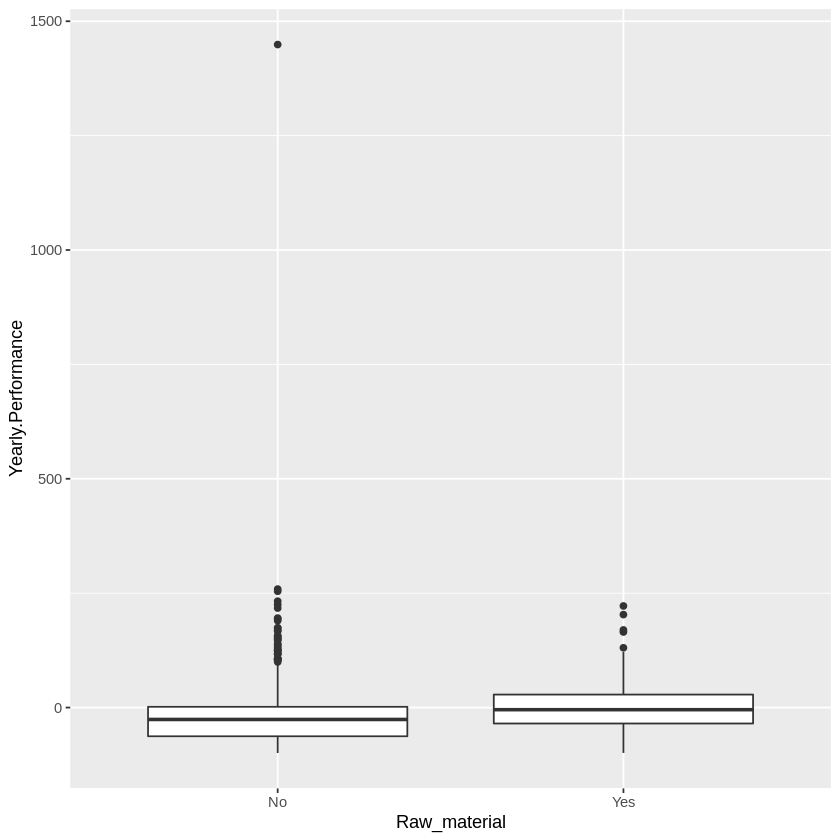

In [15]:
plot <- df %>%
    ggplot()+
    geom_boxplot(aes(x = Raw_material, y = Yearly.Performance))
plot

In [20]:
summary <- df %>%
    group_by(Raw_material)%>%
    summarize(Mean = mean(Yearly.Performance))
summary

Raw_material,Mean
<chr>,<dbl>
No,-27.977409
Yes,-2.732515


## Methods: Plan

## References